<footer id="footer"></footer>

<h1 align='center'>Languages models. Part-Of-Speech Tagger</h1>
<p align="center"><img src="https://drive.google.com/uc?id=1oAlTVkQ-v0bioVY0VgUMKbJq8MWvr8tx" alt="churn" border="0"></a></p>





---

<b> **Baseline** подготовлен [Deep learning school](#https://www.dlschool.org/pro-track)

<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/К содержанию-&#x21A9-blue'></a>
</div>

___


### Задача определения частей речи, Part-Of-Speech Tagger (POS)

Мы будем решать задачу определения частей речи (`POS-теггинга`) с помощью скрытой марковской модели (`HMM`).

In [ ]:
!pip install -q rnnmorph

In [ ]:
!pip install -q torchtext==0.6.0

In [ ]:
import time
import nltk
import math
import matplotlib

import warnings
import numpy as np
import pandas as pd
from nltk.corpus import brown
import matplotlib.pyplot as plt
from IPython.display import clear_output
from collections import OrderedDict, deque, Counter
from copy import deepcopy
from tqdm.autonotebook import tqdm
import torch

from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from nltk.tag import DefaultTagger
from nltk.tag.mapping import map_tag
from rnnmorph.predictor import RNNMorphPredictor
from sklearn.model_selection import train_test_split
import torchtext
from torchtext import datasets
from torchtext import data


%matplotlib inline
matplotlib.rcParams.update({'figure.figsize': (15, 10), 'font.size': 11})
warnings.filterwarnings("ignore")

report = pd.DataFrame()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


Руководство: http://www.nltk.org/book/

Загрузим brown корпус

In [ ]:
nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

Существует множество наборов грамматических тегов, или тегсетов, например:
* `НКРЯ`
* `Mystem`
* `UPenn`
* `OpenCorpora` (его использует `pymorphy2`)
* `Universal Dependencies`

<b>Существует не одна система тегирования, поэтому будьте внимательны, когда прогнозируете тег слов в тексте и вычисляете качество прогноза. Можете получить несправедливо низкое качество вашего решения.

На данный момент стандартом является **Universal Dependencies**. Подробнее про проект можно почитать [вот тут](http://universaldependencies.org/), а про теги — [вот тут](http://universaldependencies.org/u/pos/)

In [ ]:
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

Мы имеем массив предложений пар (слово-тег)

In [ ]:
brown_tagged_sents = brown.tagged_sents(tagset="universal")

Первое предложение

In [ ]:
brown_tagged_sents[0]

[('The', 'DET'),
 ('Fulton', 'NOUN'),
 ('County', 'NOUN'),
 ('Grand', 'ADJ'),
 ('Jury', 'NOUN'),
 ('said', 'VERB'),
 ('Friday', 'NOUN'),
 ('an', 'DET'),
 ('investigation', 'NOUN'),
 ('of', 'ADP'),
 ("Atlanta's", 'NOUN'),
 ('recent', 'ADJ'),
 ('primary', 'NOUN'),
 ('election', 'NOUN'),
 ('produced', 'VERB'),
 ('``', '.'),
 ('no', 'DET'),
 ('evidence', 'NOUN'),
 ("''", '.'),
 ('that', 'ADP'),
 ('any', 'DET'),
 ('irregularities', 'NOUN'),
 ('took', 'VERB'),
 ('place', 'NOUN'),
 ('.', '.')]

Все пары (слово-тег)

In [ ]:
brown_tagged_words = brown.tagged_words(tagset='universal')
brown_tagged_words

[('The', 'DET'), ('Fulton', 'NOUN'), ...]

Проанализируйте данные, с которыми Вы работаете. Используйте `nltk.FreqDist()` для подсчета частоты встречаемости тега и слова в нашем корпусе. Под частой элемента подразумевается кол-во этого элемента в корпусе.

In [ ]:
# Приведем слова к нижнему регистру
brown_tagged_words = list(map(lambda x: (x[0].lower(), x[1]), brown_tagged_words))

In [ ]:
print('Кол-во предложений: ', len(brown_tagged_sents))
tags = [tag for (word, tag) in brown_tagged_words] # наши теги
words = [word for (word, tag) in brown_tagged_words] # наши слова

tag_num = pd.Series(nltk.FreqDist(tags)).sort_values(ascending=False)\
                                        .rename({".": "PUNCT"}) # тег - кол-во тега в корпусе
word_num = pd.Series(nltk.FreqDist(words)).sort_values(ascending=False) # слово - кол-во слова в корпусе

Кол-во предложений:  57340


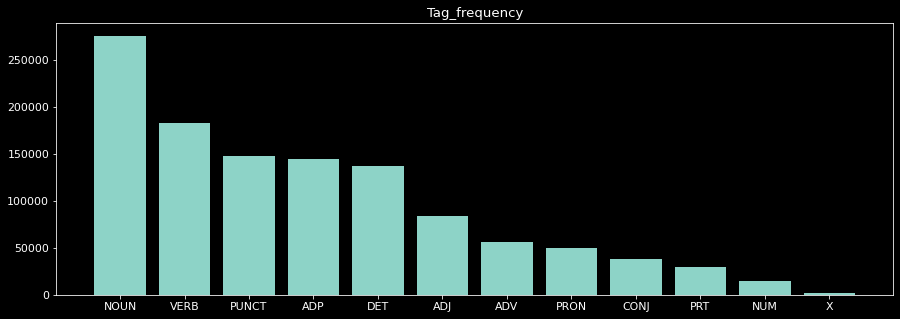

In [ ]:
# для красоты переимновали . в PUNCT
plt.style.use('dark_background')
plt.figure(figsize=(15, 5))
plt.bar(tag_num.index, tag_num.values)
plt.title("Tag_frequency")
plt.show()

In [ ]:
word_num[:5].to_frame('cnt')

,cnt
the,69971
",",58334
.,49346
of,36412
and,28853


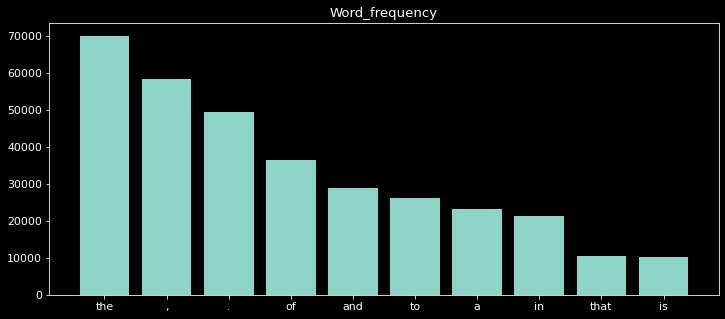

In [ ]:
plt.figure(figsize=(12, 5))
plt.bar(word_num.index[:10], word_num.values[:10])
plt.title("Word_frequency")
plt.show()

In [ ]:
cat_nums = word_num["cat"]
print(f"Количество слова \033[1m'cat'\033[0m в корпусе: {cat_nums} слов(-а)")

Количество слова 'cat' в корпусе: 23 слов(-а)


<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/К содержанию-&#x21A9-blue'></a>
</div>

___


In [ ]:
pop_tag = tag_num.nlargest(1).index.item()
words_with_poptag = [word for (word, tag) in brown_tagged_words if tag == pop_tag]
word_num_pop = pd.Series(nltk.FreqDist(words_with_poptag)).sort_values(ascending=False)
pop_word = word_num_pop.nlargest(1).index.item()
print(f"Самое популярное слово в корпусе: \033[1m{pop_word}\033[0m")

Самое популярное слово в корпусе: time


<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/К содержанию-&#x21A9-blue'></a>
</div>

___


Обучение может занимать много времени - иногда, хорошим решением будет работа с подвыборкой. Мы можем помостреть категории корпуса:

In [ ]:
brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

Будем работать с категорией `humor`

**UPDATE**. Во второй итерации работаем со всем сетом. Данные по обучению в `subset` - `humor` - хранится в итоговой таблице

Сделаем случайное разбиение выборки на обучение и контроль в отношении 9:1. 

In [ ]:
# brown_tagged_sents = brown.tagged_sents(tagset="universal", categories='humor')
# вторая итерация - весь сет

brown_tagged_sents = brown.tagged_sents(tagset="universal")

# Приведем слова к нижнему регистру
my_brown_tagged_sents = []
for sent in brown_tagged_sents:
    my_brown_tagged_sents.append(list(map(lambda x: (x[0].lower(), x[1]), sent)))
my_brown_tagged_sents = np.array(my_brown_tagged_sents)


train_sents, test_sents = train_test_split(my_brown_tagged_sents, test_size=.1, random_state=42)
assert (test_sents.shape[0] + train_sents.shape[0], ) == my_brown_tagged_sents.shape

### Метод максимального правдоподобия для обучения модели

* $\normalsize S = s_0, s_1, ..., s_N$ - скрытые состояния, то есть различные теги
* $\normalsize O = o_0, o_1, ..., o_M$ - различные слова
* $\normalsize a_{i,j} = p(s_j|s_i)$ - вероятность того, что, находясь в скрытом состоянии $s_i$, мы попадем в состояние $s_j$ (элемент матрицы $A$)
* $\normalsize b_{k,j}=p(o_k|s_j)$ - вероятность того, что при скрытом состоянии $s_j$ находится слово $o_k$(элемент матрицы $B$)

$$\normalsize x_t \in O, y_t \in S$$
$\normalsize (x_t, y_t)$ - слово и тег, стоящие на месте $t$ $\Rightarrow$ 
* $\normalsize X$ - последовательность слов
* $\normalsize Y$ - последовательность тегов

Требуется построить скрытую марковскую модель (`class HiddenMarkovModel`) и написать метод `fit` для настройки всех её параметров с помощью оценок максимального правдоподобия по размеченным данным (последовательности пар слово+тег):

- Вероятности переходов между скрытыми состояниями $p(y_t | y_{t - 1})$ посчитайте на основе частот биграмм POS-тегов.


- Вероятности эмиссий наблюдаемых состояний $p(x_t | y_t)$ посчитайте на основе частот "POS-тег - слово".


- Распределение вероятностей начальных состояний $p(y_0)$ задайте равномерным.

Пример $X = [x_0, x_1], Y = [y_0, y_1]$:<br><br>
$$p(X, Y) = p(x_0, x_1, y_0, y_1) = p(y_0) \cdot p(x_0, x_1, y_1 | y_0) = p(y_0) \cdot p(x_0 | y_0) \cdot
p(x_1, y_1 | x_0, y_0) = \\ = p(y_0) \cdot p(x_0 | y_0) \cdot p(y_1 | x_0, y_0) \cdot p(x_1 | x_0, y_0, y_1)
= (\text{в силу условий нашей модели}) = \\ = p(y_0) \cdot p(x_0 | y_0) \cdot p(y_1 | y_0) \cdot p(x_1 | y_1) \Rightarrow$$ <br>
Для последовательности длины $n + 1$:<br>
$$p(X, Y) = p(x_0 ... x_{n - 1}, y_0 ... y_{n - 1}) \cdot p(y_n | y_{n - 1}) \cdot p(x_n | y_n)$$

#### Алгоритм Витерби для применения модели


Требуется написать метод `.predict` для определения частей речи на тестовой выборке. Чтобы использовать обученную модель на новых данных, необходимо реализовать алгоритм Витерби. Это алгоритм динамиеского программирования, с помощью которого мы будем находить наиболее вероятную последовательность скрытых состояний модели для фиксированной последовательности слов:

$$ \hat{Y} = \arg \max_{Y} p(Y|X) = \arg \max_{Y} p(Y, X) $$

Пусть $\normalsize Q_{t,s}$ - самая вероятная последовательность скрытых состояний длины $t$ с окончанием в состоянии $s$. $\normalsize q_{t, s}$ - вероятность этой последовательности.
$$(1)\: \normalsize q_{t,s} = \max_{s'} q_{t - 1, s'} \cdot p(s | s') \cdot p(o_t | s)$$
$\normalsize Q_{t,s}$ можно восстановить по argmax-ам.

In [ ]:
class HiddenMarkovModel:    
    def __init__(self):
    
        pass
        
    def fit(self, train_tokens_tags_list):
        """
        train_tokens_tags_list: массив предложений пар слово-тег (выборка для train) 
        """
        tags = [tag for sent in train_tokens_tags_list
                for (word, tag) in sent]
        words = [word for sent in train_tokens_tags_list
                 for (word, tag) in sent]
        
        tag_num = pd.Series(nltk.FreqDist(tags)).sort_index()
        word_num = pd.Series(nltk.FreqDist(words)).sort_values(ascending=False)
         
        self.tags = tag_num.index
        self.words = word_num.index
        self.pop_word = HiddenMarkovModel._find_pop_word(train_tokens_tags_list)
        
        A = pd.DataFrame({'{}'.format(tag) : [0] * len(tag_num) for tag in tag_num.index}, index=tag_num.index)
        B = pd.DataFrame({'{}'.format(tag) : [0] * len(word_num) for tag in tag_num.index}, index=word_num.index)
        
        # Вычисляем матрицу A и B по частотам слов и тегов
        
        # sent - предложение
        # sent[i][0] - i слово в этом предложении, sent[i][1] - i тег в этом предложении
        for sent in train_tokens_tags_list:
            for i in range(len(sent)):
                B.loc[sent[i][0], sent[i][1]] += 1 # текущая i-пара слово-тег (обновите матрицу B аналогично A)
                if len(sent) - 1 != i: # для последнего тега нет следующего тега
                    A.loc[sent[i][1], sent[i + 1][1]] += 1 # пара тег-тег
                
        
        # переходим к вероятностям
        
        # нормируем по строке, то есть по всем всевозможным следующим тегам
        A = A.divide(A.sum(axis=1), axis=0)
        
        # нормируем по столбцу, то есть по всем всевозможным текущим словам
        B = B / np.sum(B, axis=0)
        
        self.A = A
        self.B = B
        
        return self
        
    
    def predict(self, test_tokens_tags_list):
        """
        test_tokens_list : массив предложений пар слово-тег (выборка для test)
        """
        test_tokens_list = deepcopy(test_tokens_tags_list)
        predict_tags = OrderedDict({i : np.array([]) for i in range(len(test_tokens_list))})
        
        for i_sent in range(len(test_tokens_list)):
            
            current_sent = test_tokens_list[i_sent] # текущее предложение
            len_sent = len(current_sent) # длина предложения 
            
            q = np.zeros(shape=(len_sent + 1, len(self.tags)))
            q[0] = 1 # нулевое состояние (равномерная инициализация по всем s)
            back_point = np.zeros(shape=(len_sent + 1, len(self.tags))) # argmax
            
            for t in range(len_sent):
                
                # если мы не встречали такое слово в обучении, то вместо него будет 
                # самое популярное слово с самым популярным тегом (вопрос 2)
                if current_sent[t] not in self.words:
                    current_sent[t] = self.pop_word
                    
                # через max выбираем следующий тег
                for i_s in range(len(self.tags)):
                    
                    s = self.tags[i_s]
                    proba = q[t, :] * self.A.loc[:, s] * self.B.loc[current_sent[t], s]
                    # формула (1)
                    q[t + 1][i_s] = np.max(proba) 

                    # argmax формула(1)
                    
                    # argmax, чтобы восстановить последовательность тегов
                    back_point[t + 1][i_s] = (proba).reset_index()[s].idxmax() # индекс 
                    
            back_point = back_point.astype('int')
            
            # выписываем теги, меняя порядок на реальный
            back_tag = deque()
            current_tag = np.argmax(q[len_sent])
            for t in range(len_sent, 0, -1):
                back_tag.appendleft(self.tags[current_tag])
                current_tag = back_point[t, current_tag]
             
            predict_tags[i_sent] = np.array(back_tag)
        return predict_tags     

    @classmethod
    def _find_pop_word(cls, train_tokens_tags_list):

      tags = [tag for sent in train_tokens_tags_list
        for (word, tag) in sent]
      words = [word for sent in train_tokens_tags_list
                for (word, tag) in sent]

      tag_num = pd.Series(nltk.FreqDist(tags)).sort_values(ascending=False)
      word_num = pd.Series(nltk.FreqDist(words)).sort_values(ascending=False)

      pop_tag = tag_num.nlargest(1).index.item()
      words_with_poptag = [word for sent in train_tokens_tags_list
                          for (word, tag) in sent if tag == pop_tag]
      word_num_pop = pd.Series(nltk.FreqDist(words_with_poptag)).sort_values(ascending=False)
      pop_word = word_num_pop.nlargest(1).index.item()

      return pop_word

Обучите скрытую марковскую модель:

In [ ]:
model = HiddenMarkovModel()
model.fit(train_sents)

Проверьте работу реализованного алгоритма на следующих модельных примерах, проинтерпретируйте результат.

- 'He can stay'
- 'a cat and a dog'
- 'I have a television'
- 'My favourite character'

In [ ]:
sents = [['He', 'can', 'stay'], ['a', 'cat', 'and', 'a', 'dog'], ['I', 'have', 'a', 'television'],
         ['My', 'favourite', 'character']]

In [ ]:
predictions = model.predict(sents)

In [ ]:
predictions

OrderedDict([(0, array(['NOUN', 'VERB', 'VERB'], dtype='<U4')),
             (1, array(['DET', 'NOUN', 'CONJ', 'DET', 'NOUN'], dtype='<U4')),
             (2, array(['NOUN', 'VERB', 'DET', 'NOUN'], dtype='<U4')),
             (3, array(['NOUN', 'NOUN', 'NOUN'], dtype='<U4'))])

Мы видим, что по всем предложениям предсказан правильный `tag`, есть вопросы только к последнему - слово `favorite` - предсказали `NOUN`, но в данном контексте `ADJ`

In [ ]:
nltk.FreqDist([(word, tag) for (word, tag) in brown_tagged_words if word == 'favorite'])

FreqDist({('favorite', 'ADJ'): 37, ('favorite', 'NOUN'): 4})

Но как мы видим, что слово `favorite` представлено в двух вариантах. Но стоит отметить, что в нашем случае - лучшим вариантом было бы проставить `ADJ`, но модель решила, что верно - `NOUN`

<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/К содержанию-&#x21A9-blue'></a>
</div>

___


In [ ]:
idx = sents[0].index("can")
print(f"Для слова 'can' получили тэг: {predictions[0][idx]}")

Для слова 'can' получили тэг: VERB


<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/К содержанию-&#x21A9-blue'></a>
</div>

___


In [ ]:
idx = sents[3].index("favourite")
print(f"Для слова 'favourite' получили тэг: {predictions[3][idx]}")

Для слова 'favourite' получили тэг: NOUN


Примените модель к отложенной выборке Брауновского корпуса и подсчитайте точность определения тегов (accuracy). Сделайте выводы. 

In [ ]:
def accuracy_score(model, sents, subset='_humor'):
    report = pd.Series()
    true_pred = 0
    num_pred = 0

    for sent in sents:  
      tags = np.array([tag for (word, tag) in sent])
      words = [word for (word, tag) in sent]
      preds = np.array(list(dict(model.predict([words])).values())[0].tolist())
      true_pred += np.sum(preds == tags)
      num_pred += len(words)
      acc = round(true_pred / num_pred * 100, 1)
    print("Accuracy, %:", round(true_pred / num_pred * 100, 1))
    return pd.Series({"model": model.__class__.__name__ + subset, "acc": acc})

In [ ]:
rep_005 = accuracy_score(model, test_sents, subset="_whole")

Accuracy, %: 96.2


<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/К содержанию-&#x21A9-blue'></a>
</div>

___


## DefaultTagger

Вы можете испоьзовать `DefaultTagger`(метод `tag` для предсказания частей речи предложения)

In [ ]:
def accuracy_score_default(default_tagger, sents, subset='_humor'):
    true_pred = 0
    num_pred = 0
    for sent in sents:  
      tags = np.array([tag for (word, tag) in sent])
      words = [word for (word, tag) in sent]
      preds = [tag for s in default_tagger.tag_sents([words]) for (word, tag) in s]
      true_pred += np.sum(preds == tags)
      num_pred += len(words)
      acc = round(true_pred / num_pred * 100, 1)
    print("Accuracy, %:", acc)
    return pd.Series({"model": default_tagger.__class__.__name__+subset, "acc": acc})

In [ ]:
default_tagger = DefaultTagger(pop_tag)

In [ ]:
rep_006 = accuracy_score_default(default_tagger, test_sents, subset="_whole")

Accuracy, %: 23.6


<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/К содержанию-&#x21A9-blue'></a>
</div>

___


## NLTK, Rnnmorph


Не забудьте преобразовать систему тэгов из `'en-ptb' в 'universal'` с помощью функции `map_tag` или используйте `tagset='universal'`

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
predictor = RNNMorphPredictor(language="en")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [ ]:
def accuracy_score_RNN(model, sents, subset='_humor'):
    report = pd.Series()
    true_pred = 0
    num_pred = 0

    for sent in sents[:1]:  
      tags = np.array([tag for (word, tag) in sent])
      words = [word for (word, tag) in sent]
      preds = [[token.pos for token in predictor.predict([word])][0] for word in words]
      true_pred += np.sum(preds == tags)
      num_pred += len(words)
      acc = round(true_pred / num_pred * 100, 1)
    print("Accuracy, %:", round(true_pred / num_pred * 100, 1))
    return pd.Series({"model": model.__class__.__name__+subset, "acc": acc})

In [ ]:
rep_007 = accuracy_score_RNN(predictor, test_sents, subset="_whole")

При импользовании `humor`-subset - получили `50%` качества Accuracy

In [ ]:
(pd.DataFrame([rep_001, rep_002, rep_003])
 .sort_values(by="acc", ascending=False)
 .reset_index(drop=True)
 .style
 .highlight_max(subset="acc", color="green")
 .highlight_min(subset="acc", color="red")
 .set_caption('Сравнительная таблица результатов POS-предсказаний трех моделей')
)

,model,acc
0,HiddenMarkovModel_humor,88.900000
1,RNNMorphPredictorhumor,50.000000
2,DefaultTagger_humor,19.600000


В `RNNMorphPredictor` более строго и независимо от регистра ставится тэг `pronoun`, тогда как ранее для местоимений - в нижнем регистре проставлялся тэг `Noun`

Лучшие результаты получены на скрытой марковской модели. Худшие - на `DefaultTagger`

## BiLSTMTagger

### Подготовка данных

Изменим структуру данных

In [ ]:
pos_data = [list(zip(*sent)) for sent in brown_tagged_sents]
print(pos_data[0][:1])

[('The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.')]


До этого мы писали много кода сами, теперь пора эксплуатировать pytorch

In [ ]:
# наши поля
WORD = data.Field(lower=True)
TAG = data.Field(unk_token=None) # все токены нам известны

# создаем примеры
examples = []
for words, tags in pos_data:
    examples.append(torchtext.data.Example.fromlist([list(words), list(tags)], fields=[('words', WORD), ('tags', TAG)]))

Вот один наш пример:

In [ ]:
print(vars(examples[0]))

{'words': ['the', 'fulton', 'county', 'grand', 'jury', 'said', 'friday', 'an', 'investigation', 'of', "atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'], 'tags': ['DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'NOUN', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.']}


Теперь формируем наш датасет

In [ ]:
# кладем примеры в наш датасет
dataset = torchtext.data.Dataset(examples, fields=[('words', WORD), ('tags', TAG)])

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.1, 0.1])

print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 45872
Number of validation examples: 5734
Number of testing examples: 5734


Построим словари. Параметр `min_freq` выберете сами. При построении словаря испольузем только **train**

In [ ]:
WORD.build_vocab(train_data, min_freq=2)
TAG.build_vocab(train_data)

print(f"Unique tokens in source (ru) vocabulary: {len(WORD.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TAG.vocab)}")

print(WORD.vocab.itos[::200])
print(TAG.vocab.itos)

Unique tokens in source (ru) vocabulary: 24763
Unique tokens in target (en) vocabulary: 13
['<unk>', 'away', 'office', 'range', 'immediately', "i'd", 'mary', 'economy', 'mercer', 'academic', 'loose', 'silent', 'bonds', 'determination', 'maris', 'stick', 'bus', 'cried', 'signals', 'extending', 'promotion', 'voted', 'backward', 'basically', 'uncertain', 'sheep', 'mistakes', 'dare', 'superintendent', 'hiding', '800', 'lecture', 'array', 'marty', 'aegean', 'hemisphere', 'scotland', 'commercially', 'instrumental', 'shed', 'bin', 'gigantic', 'pour', 'unnatural', 'climbing', 'fresco', 'occupying', 'spade', 'aaron', 'coins', 'fille', 'keel', 'postponed', 'spherical', '$2,000', 'blurred', 'criticality', 'forgiven', 'juicy', 'out-of-doors', 'roasted', 'technician', '29th', 'biscuits', 'consoles', 'dynasty', 'gasped', 'insignificant', 'milstein', 'perverse', 'resolutions', 'solvent', 'twelfth', '0.3', 'allusion', 'beguiling', 'cesium-137', 'courtiers', 'dorado', 'fearfully', 'grandson', 'imminent

In [ ]:
TAG.vocab.freqs.most_common()

[('NOUN', 220576),
 ('VERB', 146179),
 ('.', 118244),
 ('ADP', 115550),
 ('DET', 109633),
 ('ADJ', 66972),
 ('ADV', 44983),
 ('PRON', 39360),
 ('CONJ', 30618),
 ('PRT', 23909),
 ('NUM', 11862),
 ('X', 1103)]

In [ ]:
print(vars(train_data.examples[9]))

{'words': ['the', 'director', 'of', 'the', 'peace', 'corps', ',', 'r.', 'sargent', 'shriver', ',', 'jr.', ',', 'a', 'kennedy', 'brother-in-law', ',', 'collects', 'heavily', 'among', 'the', 'moderns', ',', 'including', 'kenzo', 'okada', 'and', 'josef', 'albers', '.'], 'tags': ['DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'NOUN', '.', 'NOUN', 'NOUN', 'NOUN', '.', 'NOUN', '.', 'DET', 'NOUN', 'NOUN', '.', 'VERB', 'ADV', 'ADP', 'DET', 'NOUN', '.', 'ADP', 'NOUN', 'NOUN', 'CONJ', 'NOUN', 'NOUN', '.']}


Посмотрим с насколько большими предложениями мы имеем дело

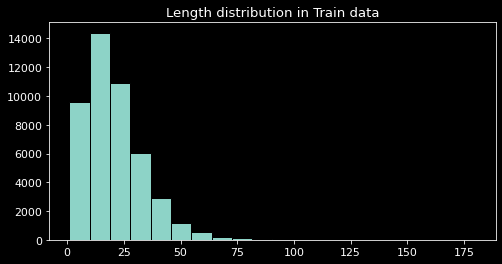

In [ ]:
length = map(len, [vars(x)['words'] for x in train_data.examples])

plt.figure(figsize=[8, 4])
plt.title("Length distribution in Train data")
plt.hist(list(length), bins=20, ec='black');

Для обучения `BiLSTM` лучше использовать colab

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Для более быстрого и устойчивого обучения сгруппируем наши данные по батчам

In [ ]:
# бьем нашу выборку на батч, не забывая сначала отсортировать выборку по длине
def _len_sort_key(x):
    return len(x.words)

BATCH_SIZE = 32

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [ ]:
# посморим  на количество батчей
list(map(len, [train_iterator, valid_iterator, test_iterator]))

[1434, 180, 180]

### Модель и её обучение

Инициализируем нашу модель

In [ ]:
class LSTMTagger(nn.Module):

    def __init__(self, 
                 input_dim, 
                 emb_dim, 
                 hid_dim, 
                 output_dim,
                 dropout, 
                 pad_idx,
                 bidirectional=False):
        super().__init__()
        
  
        self.embeddings = nn.Embedding(input_dim, 
                                       emb_dim,
                                       pad_idx)
        self.dropout = nn.Dropout(dropout)
        
        self.rnn = nn.LSTM(emb_dim,
                           hid_dim, 
                           num_layers=2,
                           bidirectional=bidirectional)
        # если bidirectional, то предсказываем на основе конкатенации двух hidden
        
        self.tag = nn.Linear((1 + bidirectional) * hid_dim, output_dim)
        
    def forward(self, sent):
        
        #sent = [sent len, batch size] 
        
        # не забываем применить dropout к embedding
        embedded = self.dropout(self.embeddings(sent))
        #output = [sent len, batch size, hid dim * n directions]

        output, _ = self.rnn(embedded)
        prediction = self.tag(self.dropout(output))
        return prediction
        
# параметры модели
INPUT_DIM = len(WORD.vocab)
OUTPUT_DIM = len(TAG.vocab)
EMB_DIM = 64
HID_DIM = 64
DROPOUT = .1
BIDIRECTIONAL = True
PAD_IDX = TAG.vocab.stoi[TAG.pad_token]

model = LSTMTagger(input_dim=INPUT_DIM, 
                   emb_dim=EMB_DIM, 
                   hid_dim=HID_DIM,
                   output_dim=OUTPUT_DIM,
                   dropout=DROPOUT,
                   pad_idx=PAD_IDX,
                   bidirectional=BIDIRECTIONAL).to(device)

# инициализируем веса
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

LSTMTagger(
  (embeddings): Embedding(24763, 64, padding_idx=0)
  (dropout): Dropout(p=0.1, inplace=False)
  (rnn): LSTM(64, 64, num_layers=2, bidirectional=True)
  (tag): Linear(in_features=128, out_features=13, bias=True)
)

Подсчитаем количество обучаемых параметров нашей модели

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,752,397 trainable parameters


Время обучать

In [ ]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        optimizer.zero_grad()
        tags = batch.tags
        features = batch.words
        #tags = [sent len, batch size]
        #output = [sent len, batch size, output dim]
        output = model(features)

        #tags = [sent len * batch size]
        #output = [sent len * batch size, output dim]

        output = output.view(-1, output.shape[-1])
        tags = tags.view(-1)
        loss = criterion(output, tags)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)

        optimizer.step()
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    history = []
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):

            tags = batch.tags
            features = batch.words
            #tags = [sent len, batch size]
            #output = [sent len, batch size, output dim]
            output = model(features)

            #tags = [sent len * batch size]
            #output = [sent len * batch size, output dim]
            
            output = output.view(-1, output.shape[-1])
            tags = tags.view(-1)
            loss = criterion(output, tags)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

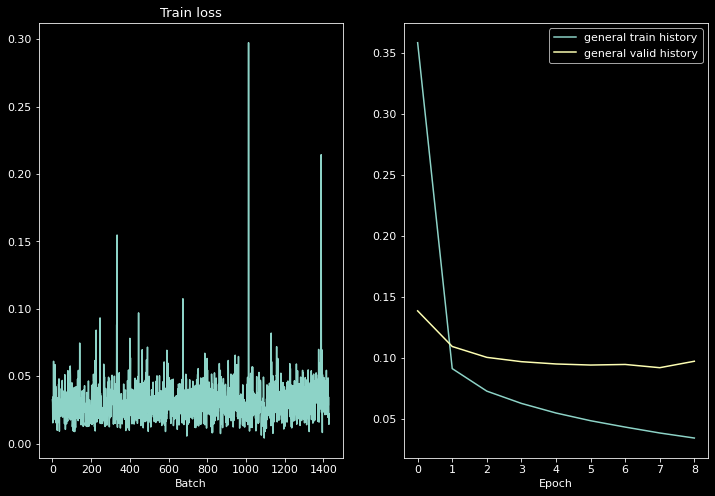

Epoch: 10 | Time: 4m 3s
	Train Loss: 0.030 | Train PPL:   1.031
	 Val. Loss: 0.098 |  Val. PPL:   1.103


In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

### Применение модели

In [ ]:
def accuracy_model(model, iterator, subset='humor'):
    model.eval()
    
    true_pred = 0
    num_pred = 0
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):

            tags = batch.tags
            features = batch.words

            output = model(features)
            
            output = output.view(-1, output.shape[-1])
            output = torch.argmax(output, 1).long()
            predict_tags = output.cpu().numpy()
            true_tags = tags.view(-1).cpu().numpy()
            
            true_pred += np.sum((true_tags == predict_tags) & (true_tags != PAD_IDX))
            num_pred += np.prod(true_tags.shape) - (true_tags == PAD_IDX).sum()
    acc = round(true_pred / num_pred * 100, 3)
    print("Accuracy:", acc , '%')
    return pd.Series({"model": model.__class__.__name__+subset, "acc": acc}) 

In [ ]:
res_008 = accuracy_model(model, test_iterator, subset="_whole")

Accuracy: 97.372 %


Вы можете улучшить качество, изменяя параметры модели. Но чтобы добиться нужного качества, вам неообходимо взять все выборку, а не только категорию `humor`.

In [ ]:
brown_tagged_sents = brown.tagged_sents(tagset="universal")

Нам неоходимо добиться качества не меньше, чем `accuracy = 93 %`. Попробуем взять весь сет

In [ ]:
best_model = LSTMTagger(input_dim=INPUT_DIM, 
                   emb_dim=EMB_DIM, 
                   hid_dim=HID_DIM,
                   output_dim=OUTPUT_DIM,
                   dropout=DROPOUT,
                   pad_idx=PAD_IDX,
                   bidirectional=BIDIRECTIONAL).to(device)
best_model.load_state_dict(torch.load('best-val-model.pt'))
res = accuracy_model(model, test_iterator)["acc"].item()
assert res >= 93

Accuracy: 97.372 %


Пример решение нашей задачи:

In [ ]:
def print_tags(model, data):
    model.eval()
    
    with torch.no_grad():
        words, _ = data
        example = torch.LongTensor([WORD.vocab.stoi[elem] for elem in words]).unsqueeze(1).to(device)
        
        output = model(example).argmax(dim=-1).cpu().numpy()
        tags = [TAG.vocab.itos[int(elem)] for elem in output]

        for token, tag in zip(words, tags):
            print(f'{token:15s}{tag}')

In [ ]:
print_tags(model, pos_data[-1])

From           VERB
what           DET
I              NOUN
was            VERB
able           ADJ
to             ADP
gauge          NOUN
in             ADP
a              DET
swift          ADJ
,              .
greedy         ADJ
glance         NOUN
,              .
the            DET
figure         NOUN
inside         ADP
the            DET
coral-colored  ADJ
boucle         NOUN
dress          NOUN
was            VERB
stupefying     VERB
.              .


Достаточно неплохое качество `POS`-предсказний. Посмотрим в сравнении с вероятностной моделью

<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/К содержанию-&#x21A9-blue'></a>
</div>

___


## Сравнение результатов моделей:
* при обучение на маленькой части корпуса - `humor`
* при обучении на всем корпусе

In [ ]:
(pd.DataFrame([rep_001, res_004,
               rep_005, res_008])
 .sort_values(by="acc", ascending=False)
 .reset_index(drop=True)
 .style
 .highlight_max(subset="acc", color="green")
 .highlight_min(subset="acc", color="red")
 .set_caption('Сравнительная таблица результатов POS-предсказаний моделей')
)

,model,acc
0,LSTMTagger_whole,97.372000
1,HiddenMarkovModel_whole,96.200000
2,HiddenMarkovModel_humor,88.900000
3,LSTMTaggerhumor,85.908000


На всем сете - лучше всего работаем модель на базе `LSTM`, при этом у нее быстрее скорость работы, относительно `HiddenMarkovModel`, но при этом она проигрывает, если обучаться на `subset` - `humor`. Таким образом, обучение модели на всем доступном датасете позволило увеличить точность предсказаний до `97%`, но вероятностный подход не сильно уступает работе модели на базе `NN`

<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/К содержанию-&#x21A9-blue'></a>
</div>

___
